# Chapter 2

<a target="_blank" href="https://colab.research.google.com/github/CausalAILab/causalai-book/blob/main/chapter2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import sys

if 'google.colab' in sys.modules:
    os.system("wget -O scm.py https://raw.githubusercontent.com/CausalAILab/causality-book/main/scm.py")

In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as T
from sympy import symbols

from IPython.display import Latex

from scm import SymbolicSCM

print(sys.version)

3.11.2 (main, Mar 27 2023, 18:39:42) [Clang 14.0.6 ]



# Definition 2.1.1 - Structural Causal Model (SCM).

A structural causal model $M$ is a 4-tuple $\langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$, where

- $\mathbf U$ is a set of background variables, also called exogenous variables, that are determined by factors outside the model;
- $\mathbf V$ is a set $\{V_1, \dots V_n\}$ of variables, called endogenous, that are determined by other variables in the model — that is, variables in $\mathbf U \cup \mathbf V$.
- $F$ is a set of functions $\{f_1, \dots f_n\}$ such that each $f_i$ is a mapping from (the respective domains of) $U_i \cup \mathbf{Pa}_i$ to $V_i$, where $U_i \subseteq \mathbf U, \mathbf{Pa}_i \subseteq \mathbf V \setminus V_i$, and the entire set $F$ forms a mapping from $\mathbf U$ to $\mathbf V$. That is, for $i = 1, \dots, n$, each $f_i \in F$ is such that

$$v_i \gets f_i(\mathbf{pa}_i, \mathbf{u}_i)$$

i.e., it assigns to a value to $V_i$ that depends on (the values of) a select set of variables in $\mathbf U \cup \mathbf V$; and

- $P(\mathbf U)$ is a probability function defined over the domain of $\mathbf U$.

## Example 2.1
Consider a game of chance described through the SCM $M^1 = \langle \mathbf U = \{U_1, U_2\}, \mathbf V = \{X, Y\}, F, P(U_1, U_2)\rangle$, where

$$F = \begin{cases}
X &\gets U_1 + U_2 \\
Y &\gets U_1 - U_2
\end{cases}$$

and $P(U_i = k) = 1/6$; $i = 1,2$; $k = 1, \dots, 6$.

In [3]:
x, y, u1, u2 = symbols('x y u1 u2')

m1 = SymbolicSCM(
    f={
        x: u1 + u2,
        y: u1 - u2,
    },
    pu={
        # each list characterizes a categorical distribution
        # the first element is the probability of the value 0
        u1: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
        u2: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    }
)
m1

SCM([x, y], [u1, u2])

In [5]:
m1.get_probability_table(u=True).head()

,u1,u2,x,y,probability
0,1,1,2,0,0.027778
1,1,2,3,-1,0.027778
2,1,3,4,-2,0.027778
3,1,4,5,-3,0.027778
4,1,5,6,-4,0.027778


In [4]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


First, we plot an empirical histogram of each variable's using $10^6$ samples drawn from its distribution.

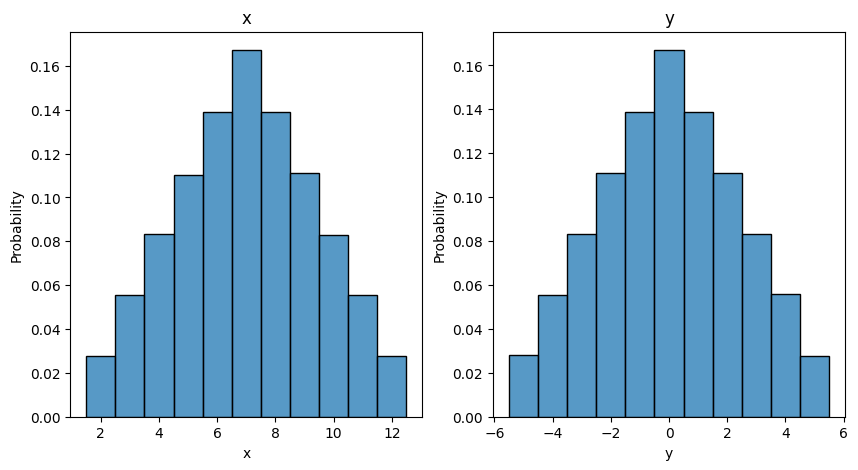

In [5]:
sample = m1.sample(n=10**6)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(sample[x], label='x', ax=axes[0], discrete=True, stat="probability")
axes[0].set_title('x')   
sns.histplot(sample[y], label='y', ax=axes[1], discrete=True, stat="probability")
axes[1].set_title('y')
plt.show()

Then, we compute the joint distribution of $X, Y$. We are able to do so in closed form, given that all variables are discrete.

In [6]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


Text(0.5, 1.0, 'Joint distribution of x and y')

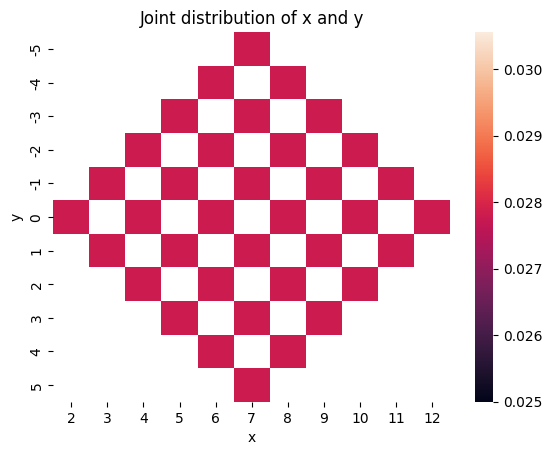

In [7]:
sns.heatmap(pd.pivot(m1.get_probability_table(), index=y, columns=x, values='probability'))
plt.title('Joint distribution of x and y')

# Definition 2.2.1 - Layer 1 Valuation - "Observing"

An SCM $M = \langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ defines a joint probability distribution $P^M(\mathbf V)$ such that for each $\mathbf Y \subseteq \mathbf V$:

$$P^M(\mathbf y) = \sum_\mathbf u \mathbf 1[\mathbf Y(\mathbf u) = \mathbf y] P(\mathbf u)$$

where $Y(\mathbf U)$ is the solution for $\mathbf Y$ after evaluating $F$ with $\mathbf U = \mathbf u$.

# Example 2.2

Consider the following SCM, where the observed variables represent a specific treatment $X$ (e.g., administering a drug), an outcome $Y$ (e.g., survival), and the presence or absence of a symptom $Z$ (e.g., hypertension). The exogenous variables consist of natural resistance to the disease $U_r$ and other unknown sources of variation $U_x, U_y, U_z$.

$$
M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_r, U_x, U_y, U_z\}\\
    F &= \begin{cases}
        Z := \mathbf 1[U_r = 1, U_z = 1]\\
        X := \mathbf 1[Z = 1, U_x = 1] + \mathbf 1[Z = 0, U_x = 0]\\
        Y := \mathbf 1[X = 1, U_r = 1] + \mathbf 1[X = 0, U_r = 1, U_y = 1] + \mathbf 1[X = 0, U_r = 0, U_y = 0]\\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_r &\sim \mathrm{Bern}(0.25) \\
       U_z &\sim \mathrm{Bern}(0.95) \\
       U_x &\sim \mathrm{Bern}(0.9) \\
       U_y &\sim \mathrm{Bern}(0.7) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [8]:
z, x, y, ur, uz, ux, uy = symbols('z x y ur uz ux uy')

m2 = SymbolicSCM(
    f={
        z: ur & uz,
        x: z & ux | ~z & ~ux,
        y: x & ur | ~x & ur & uy | ~x & ~ur & ~uy,
    },
    pu={
        ur: 0.25,
        uz: 0.95,
        ux: 0.9,
        uy: 0.7,
    }
)
m2

SCM([z, x, y], [ur, uz, ux, uy])

In [9]:
m2.get_probability_table()

,z,x,y,probability
0,0,0,0,0.475875
1,0,0,1,0.210375
2,0,1,0,0.075000
3,0,1,1,0.001250
4,1,0,0,0.007125
5,1,0,1,0.016625
6,1,1,1,0.213750


## Example 2.3 (2.2 cont.)

We can reproduce Table 2.2 in the textbook by setting `u = True` to also display exogenous variables:

In [10]:
m2.get_probability_table(u=True)

,ur,uz,ux,uy,z,x,y,probability
0,0,0,0,0,0,1,0,0.001125
1,0,0,0,1,0,1,0,0.002625
2,0,0,1,0,0,0,1,0.010125
3,0,0,1,1,0,0,0,0.023625
4,0,1,0,0,0,1,0,0.021375
5,0,1,0,1,0,1,0,0.049875
6,0,1,1,0,0,0,1,0.192375
7,0,1,1,1,0,0,0,0.448875
8,1,0,0,0,0,1,1,0.000375
9,1,0,0,1,0,1,1,0.000875


We may evaluate $P(Y = 1 | X = 1)$ as $P(Y = 1, X = 1) / P(X = 1)$ using Bayes' rule by directly querying the probability table, a pandas DataFrame.

In [11]:
pt = m2.get_probability_table()
pt.query('x == 1 and y == 1').probability.sum() / pt.query('x == 1').probability.sum()

0.7413793103448276

For convenience, we implement the equivalent `SCM.query` to compute queries.

In [12]:
m2.query({y: 1}, given={x: 1})

0.7413793103448275

The `latex` flag causes the function to output the query and value in LaTeX.

In [13]:
m2.query({y: 1}, given={x: 1}, latex=True)

<IPython.core.display.Latex object>

In [14]:
m2.query({y: 1}, given={x: 0}, latex=True)

<IPython.core.display.Latex object>

In [15]:
m2.query({z: 1}, latex=True)

<IPython.core.display.Latex object>

# Definition 2.2.2 - Submodel - "Interventional SCM"

Let $M$ be a causal model, $\mathbf X$ a set of variables in $\mathbf V$, and $\mathbf x$ a particular realization of $\mathbf X$. A submodel $M_\mathbf x$ of $M$ is the causal model

$$M_\mathbf x = \langle \mathbf U, \mathbf V, F_\mathbf x, P(\mathbf U)\rangle,$$

where

$$F_\mathbf x = \{f_i : V_i \not\in \mathbf X\} \cup \{\mathbf X \gets \mathbf x\}$$

## Definition 2.2.3 - Potential Response, Potential Outcome

Let $\mathbf X$ and $\mathbf Y$ be two sets of variables in $\mathbf V$ and $\mathbf u$ be a unit. The potential response $\mathbf Y_\mathbf x (\mathbf u)$ is defined as the solution for $\mathbf Y$ of the set of equations $F_\mathbf x$ with respect to SCM $M$ - for short, $\mathbf Y_{M_\mathbf x}(\mathbf u)$. That is,

$$\mathbf Y_\mathbf x(\mathbf u) = \mathbf Y_{M_\mathbf x}(\mathbf u).$$

## Definition 2.2.4 - Layer 2 Valuation - "Intervening"

An SCM $M =  \langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ induces a family of joint distributions over $\mathbf V$, one for each intervention $\mathbf x$. For each $\mathbf Y \subset \mathbf V$:

$$P^M(\mathbf y _ \mathbf x) = \sum_\mathbf u \mathbf 1[\mathbf Y_\mathbf x (\mathbf u) = \mathbf y] P(\mathbf u)$$

## Definition 2.2.5 - Effectiveness

A joint interventional distribution $P(\mathbf v | do(\mathbf x))$ is said to satisfy *effectiveness* if for every $V_i \in \mathbf X$,

$$P(v_i | do(\mathbf x)) = 1 \text{ if $v_i$ is consistent with $\mathbf x$ and $0$ otherwise.}$$

*Note: every interventional distribution satisfies effectiveness.*

## Example 2.4 (2.1 cont.)

Consider the SCM in Example 2.1.

In [16]:
m1

SCM([x, y], [u1, u2])

In [17]:
m1.query({y: 0}, latex=True)

<IPython.core.display.Latex object>

If we intervene on $X$, setting $X = 2$, it is evident $Y$ will not change, because it does not depend on $X$. We can see this when we replace the function for $X$ with $X = 2$.

Note that all observed variables in the interventional submodel $M_{X = 2}$ now have a subscript; the unobserved variables are unaffected by the intervention and do not change.

In [18]:
m1.do({x: 2})

SCM([{x}_{x=2}, {y}_{x=2}], [u1, u2])

In [19]:
val = m1.do({x: 2}).query({y: 0})

Latex(f'$P(y = 0 | do(x = 2)) \\approx {val:.4f}$')

<IPython.core.display.Latex object>

We are slightly abusing notation with the above expression. If we wished to be mathematically precise, we would note that we are actually querying the probability of the event $P(Y_{X = 2} = 0)$ rather than $P(Y = 0)$.

The Python data structure underlying the interventional SCM $M_{X = 2}$ has an internal mapping from the symbol $Y$ to $Y_{X = 2}$, which allows the above query to work.

The slightly more verbose - but precise - formulation of the above expression follows:

In [20]:
m1_x2 = m1.do({x: 2})
x2, y2 = m1_x2.v
m1_x2

SCM([{x}_{x=2}, {y}_{x=2}], [u1, u2])

In [21]:
m1_x2.query({y2: 0}, latex=True)

<IPython.core.display.Latex object>

We also implement a convenience mapping in $\mathcal M^1$ which remembers that $Y_{X=1}$ is derived from an intervention on $\mathcal M^1$ and allows us to write the following expression:

In [22]:
m1.query({y2: 0}, latex=True)

<IPython.core.display.Latex object>

## Example 2.5 (2.2 cont.)

Next, we consider **treatment effects**. What is the effect of treatment $X$ on medical outcome $Y$?

Can we just look at the observational quantity $P(Y = 1 | X = 1) - P(Y = 1 | X = 0)$ to make a decision on whether or not to apply the treatment?

In [25]:
val = m2.do({x: 1}).query({y: 1})

Latex(f'$P(y = 1 | do(x = 1)) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

In [26]:
val = m2.query({y: 1}, given={x: 1}) - m2.query({y: 1}, given={x: 0})
Latex(f'$P(y=1 | x=1) - P(y=1 | x=0) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

The total variation of X on Y is positive. So should we enforce the treatment $X = 1$?

Let's compare this difference to the **average treatment effect**, $P(Y = 1 | do(X = 1)) - P(Y = 1 | do(X = 0))$. This represents the difference between control and treatment group in a randomized controlled trial, where treatment assignment is randomized.

In [27]:
val = m2.do({x: 1}).query({y: 1}) - m2.do({x: 0}).query({y: 1})
Latex(f'$P(y=1 | do(x=1)) - P(y=1 | do(x=0)) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

We can see that if we enforce the treatment, $do(X = 1)$, we will actually end up harming the population more than we help it.

# Definition 2.2.6 - Layer 3 Valuation

An SCM $M = \langle\mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ induces a family of joint distributions over counterfactual events $\mathbf Y_\mathbf x, \dots, \mathbf Z_\mathbf w$ for any $\mathbf Y, \mathbf Z, \dots, \mathbf X, \mathbf W \subseteq \mathbf V$:

$$P^M(\mathbf y_\mathbf x, \dots, \mathbf z_\mathbf w) = \sum_\mathbf u \mathbf 1[\mathbf Y_\mathbf x(\mathbf u) = \mathbf y, \dots, \mathbf Z_\mathbf w(\mathbf u) = \mathbf z] P(\mathbf u)$$

## Example 2.6 (Example 2.2, cont.)

We now introduce notation for counterfactual ($L_3$) queries in code.

Say we are interested in knowing whether or not the treatment $do(X = 1)$ would have saved patients who died and did not receive the treatment ($Y = 0, X = 0$).

The variable of interest is $Y_{X = 1}$ in the SCM $M_{X=1}$, since we are hypothetically forcing the patient to take the treatment.

In [28]:
m2

SCM([z, x, y], [ur, uz, ux, uy])

In [29]:
z1, x1, y1 = m2.do({x: 1}).v
y1

{y}_{x=1}

However, the information we have is from the actual world $M$: $X = 0, Y = 0$. We write our expression as

$$P(Y_{X = 1} = 1 | X = 0, Y = 0)$$

 to describe the question: "What is the probability that the patient would have survived if they had taken the drug, given that they did not take the drug and died?"

 We may represent this query using the `y1` variable defined above from $M_{X=1}$.

In [30]:
m2.query({y1: 1}, given={x: 0, y: 0}, latex=True)

<IPython.core.display.Latex object>